# Process data

In [2]:
!pip install imgaug

     |████████████████████████████████| 948 kB 409 kB/s eta 0:00:01
     |████████████████████████████████| 49.5 MB 82 kB/s  eta 0:00:011
     |████████████████████████████████| 1.0 MB 10.3 MB/s eta 0:00:01


In [177]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import torch

# Retrieve raw data

In [180]:
BASE_PATH = "/home/jupyter/data/faces/"

In [13]:
from google.cloud import storage
client = storage.Client()

bucket_name = "tdt4173-datasets"
bucket = client.get_bucket(bucket_name)

"""
blobs = bucket.list_blobs()
for blob in blobs:
    print(blob.name)
""";

In [118]:
DATASET = "faces/videos/faces.zip"
FILEPATH = "/home/jupyter/data/faces.zip"
blob = bucket.get_blob(DATASET)
blob.download_to_filename(FILEPATH)
# faces.zip should have the following structure: class/video.xyz

In [119]:
!mkdir -p /home/jupyter/data/faces/videos
!unzip /home/jupyter/data/faces.zip -d /home/jupyter/data/faces/videos

Archive:  /home/jupyter/data/faces.zip
  inflating: /home/jupyter/data/faces/videos/__MACOSX/._Lars  
replace /home/jupyter/data/faces/videos/Lars/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


# Testing

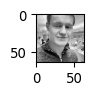

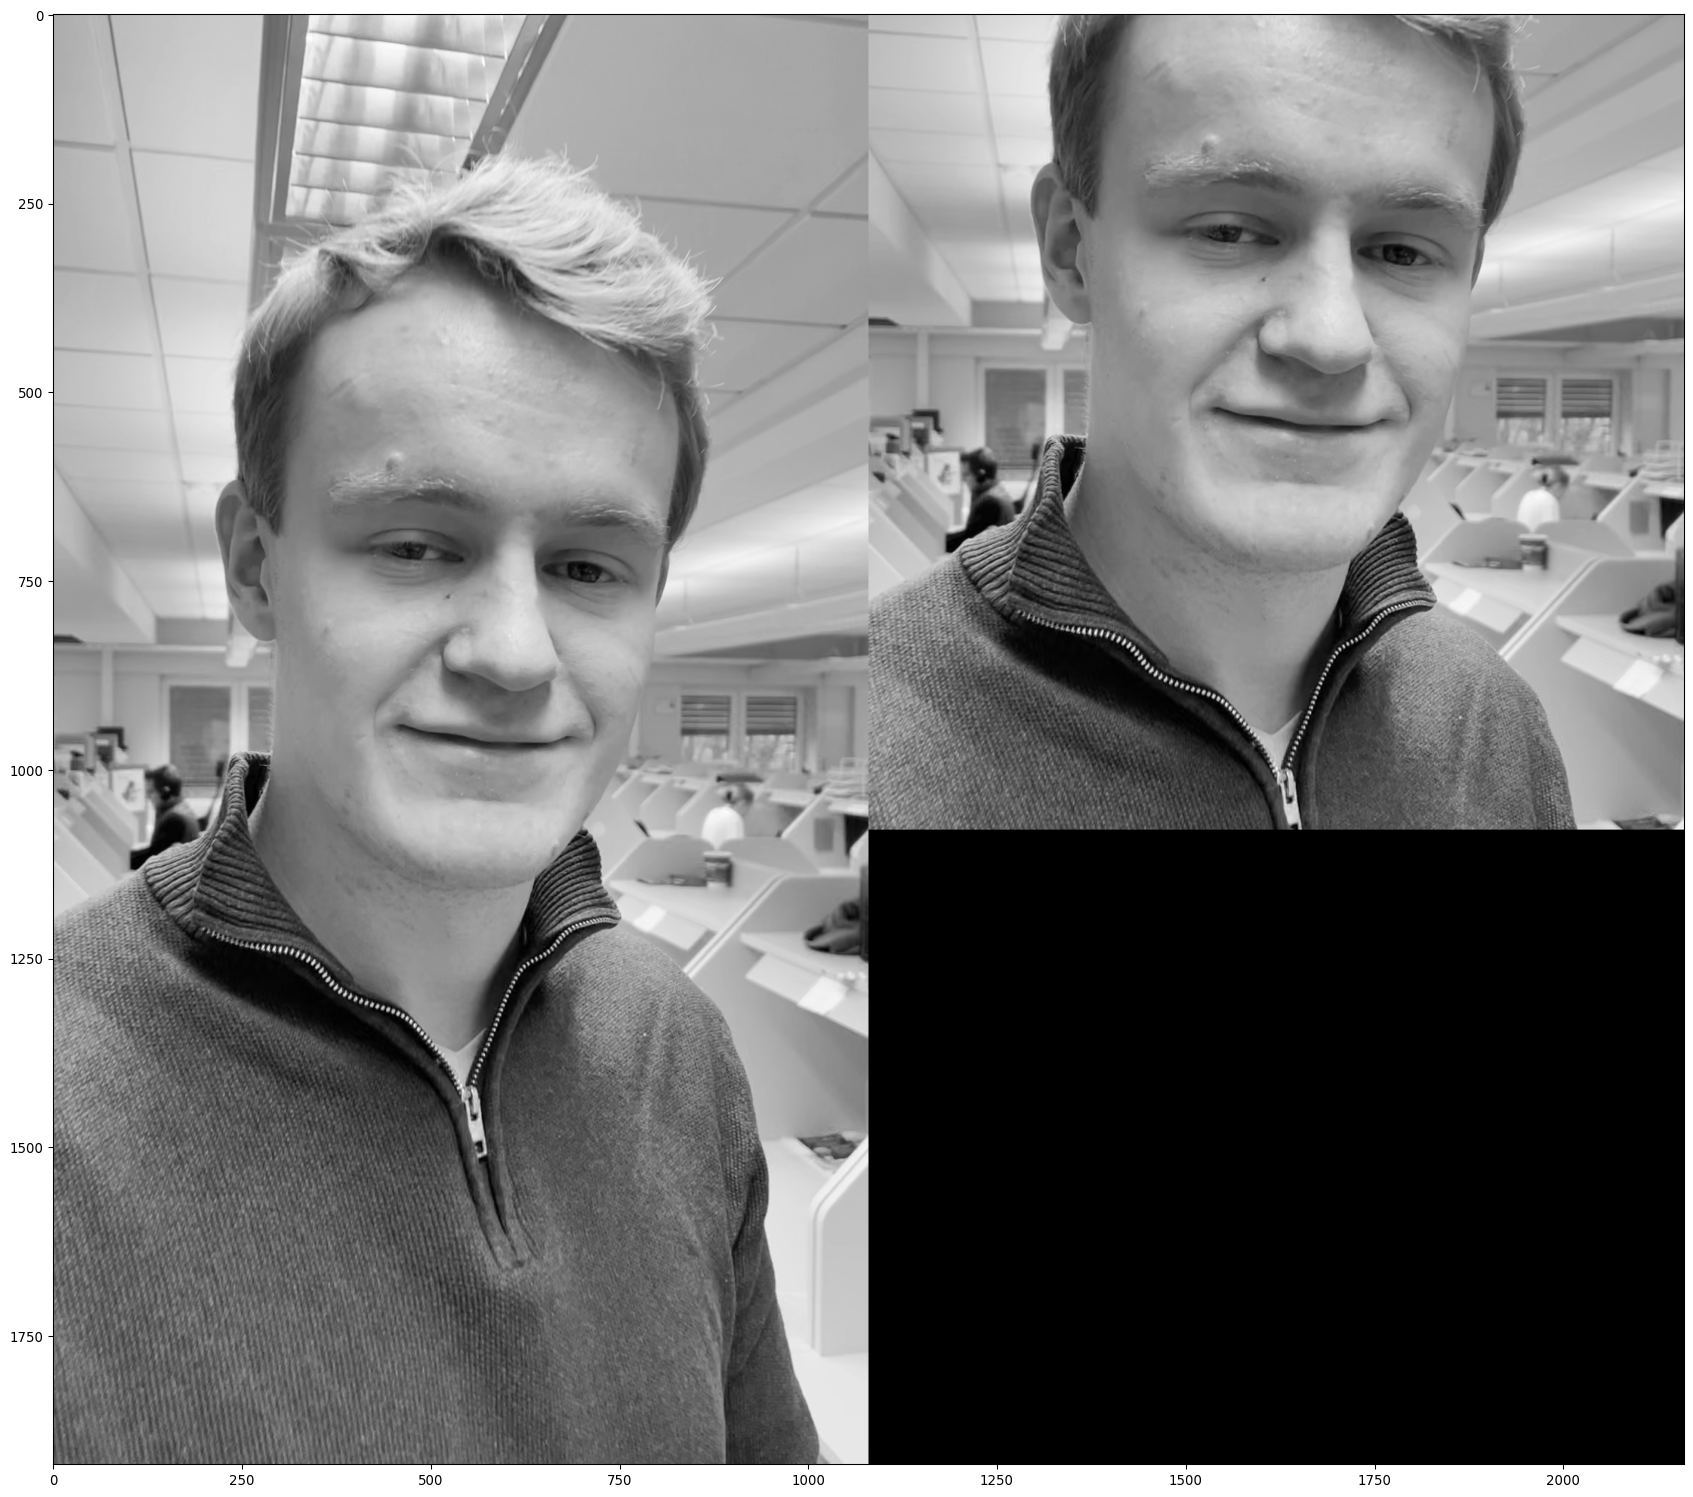

In [133]:
VIDEOPATH = "/home/jupyter/data/faces/videos/"

# Read input image
vidcap = cv2.VideoCapture("/home/jupyter/data/faces/videos/Morgan/IMG_0005.MOV")
success, image = vidcap.read()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
h, w = gray.shape # 1080x1920 (rotated 90deg left)

# Rotate
gray = np.reshape(gray, (h, w, 1))
gray = np.rot90(gray, k=3)

# Crop to square
crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
cropped = crop(image=gray)

# Downsize
img_size = 64
resized = cv2.resize(cropped, (img_size, img_size))
resized = np.reshape(resized, (img_size, img_size, 1))

ia.imshow(resized)

images = [gray, cropped]
ia.imshow(ia.draw_grid(images, cols=len(images), rows=1))

Augmented:


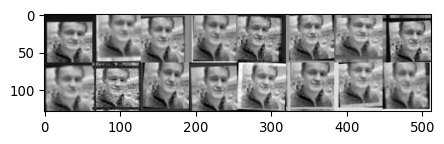

(64, 64)

In [164]:
image = resized

seq = iaa.Sequential([
    iaa.Affine(rotate=(-5, 5)),
    iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 255)),
    iaa.AdditiveGaussianNoise(scale=(0, 20)), 
    iaa.GaussianBlur(sigma=(0, 1.0)), # Blur images using a gaussian kernel with sigma between 0.0 and 1.0.
    iaa.Add((-10,10)),
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, cval=(0,255))
], random_order=True)


images_aug = [seq(image=image) for _ in range(16)] # random order is sampled once per batch, and not once per image in the batch
rows=2
print("Augmented:")
ia.imshow(ia.draw_grid(images_aug, cols=len(images_aug)/rows, rows=rows))

img = cv2.imread("/home/jupyter/data/faces/images/Morgan/morgan_98.jpg", cv2.IMREAD_GRAYSCALE)
img.shape

# Extract images

In [92]:
def preprocess_image(img, img_size=64):
    # Convert to grayscale
    # Note: we convert from BGR as VideoCapture 
    # converts the images to BGR color frame by default
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Rotate image 270 degrees to the right
    img = np.rot90(img, k=3)

    # Crop to square image
    h, w = img.shape
    crop = iaa.CropToFixedSize(height=min([h, w]), width=min([h,w]), position='center')
    img = crop(image=img)
    
    # Resize image to specified size
    img = cv2.resize(img, (img_size, img_size))
    img = np.reshape(img, (img_size, img_size, 1))
    
    return img

In [103]:
def max_label(name, folder):
    # Find maximum label of files named as "name_##.jpg" in directory
    highest = 0
    if not os.path.isdir(folder):
        return highest
    for file in os.listdir(folder):
        if name not in file:
            continue
        label = file.rpartition(os.sep)[2].split(".")[0].rpartition("_")[2]
        highest = max(highest, int(label))
    return highest

In [112]:
def extract_images_from_video(video, target_dir=None, file_prefix=None, img_size=64, processing_func=preprocess_image, silent=False):    
    """
    Saves every single frame of a video as images.
    Converts to greyscale, pads with black to make square images and resizes.
    """
    print(video)
    
    vidcap = cv2.VideoCapture(video)
    
    video_name = video.rpartition(os.sep)[2].split(".")[0]
    
    # Where to save images
    if not target_dir:
        target_dir = os.getcwd() + f"/images_from_video_{video_name}"
        os.makedirs(target_dir, exist_ok=True) 

    # Use video file name as prefix if not specified
    if not file_prefix:
        file_prefix = video_name

    label = max_label(file_prefix, target_dir)
    count = 0
    
    while True:
        # Read image from video
        success, image = vidcap.read()
        
        # if frame is read correctly, succes is True
        if not success:
            print("Can't receive frame (stream end?). Exiting ...")
            return count
        
        # Convert to greyscale, make square and resize
        image = processing_func(image, img_size)

        # Save to file
        label += 1
        count += 1
        file_name = f"{file_prefix}_{str(count)}.jpg"
        path = os.path.join(target_dir, file_name)
        cv2.imwrite(path, image) # should create directory if doesnt exist

        # Check that image is not corrupted
        if cv2.imread(path) is None:
            print(f"WARNING: image corrupted at path {path}")
            os.remove(path)
        else:
            if not silent:
                print(f'Image successfully written at {path}')


In [116]:
KJARTAN = BASE_PATH + "videos/Kjartan"
LARS = BASE_PATH + "videos/Lars"
MORGAN = BASE_PATH + "videos/Morgan"
OTHER = BASE_PATH + "videos/Other"

counts = {KJARTAN: 0, LARS: 0, MORGAN: 0, OTHER: 0}
IMAGE_SIZE = 64

# For each class, extract all frames from all videos, preprocess image and save to data/faces/label
for label in LABELS:
    count = 0
    for video in tqdm(os.listdir(label)):
        if not video.endswith(".MOV"):
            continue
        # Extract each frame of video, preprocess and save to directory
        name = label.rpartition("/")[2]
        target_dir = f"/home/jupyter/data/faces/images/{name}"
        video_path = os.path.join(label, video)
        count += extract_images_from_video(video_path, target_dir, processing_func=preprocess_image, img_size=IMAGE_SIZE, file_prefix=name.lower())
    counts[label] = count
    

print(f"Kjartan: {counts[KJARTAN]}, Lars: {counts[LARS]}, Morgan: {counts[MORGAN]}, Other: {counts[OTHER]}")


0it [00:00, ?it/s]
  0%|          | 0/2 [00:00<?, ?it/s]

/home/jupyter/data/faces/Lars/IMG_0004.MOV
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_1.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_2.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_3.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_4.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_5.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_6.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_7.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_8.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_9.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_10.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_11.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_12.jpg
Image successfully

  0%|          | 0/2 [00:00<?, ?it/s]

Image successfully written at /home/jupyter/data/faces/images/Lars/lars_143.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_144.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_145.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_146.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_147.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_148.jpg
Image successfully written at /home/jupyter/data/faces/images/Lars/lars_149.jpg
Can't receive frame (stream end?). Exiting ...
/home/jupyter/data/faces/Morgan/IMG_0005.MOV
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_1.jpg
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_2.jpg
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_3.jpg
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_4.jpg
Image successfully w

100%|██████████| 2/2 [00:03<00:00,  1.51s/it]
0it [00:00, ?it/s]

Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_139.jpg
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_140.jpg
Image successfully written at /home/jupyter/data/faces/images/Morgan/morgan_141.jpg
Can't receive frame (stream end?). Exiting ...
Kjartan: 0, Lars: 149, Morgan: 141, Other: 0


# Augment images

In [171]:
def augment_image(image, num_augmentations=19):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-5, 5)),
        iaa.CropAndPad(percent=(-0.05, 0.1), pad_mode=ia.ALL, pad_cval=(0, 255)), # crop images by -5% to 10% of their height/width
        iaa.AdditiveGaussianNoise(scale=(0, 20)), 
        iaa.GaussianBlur(sigma=(0, 1.0)), # Blur images using a gaussian kernel with sigma between 0.0 and 1.0.
        iaa.Add((-10,10)), # change brightness of images (by -10 to 10 of original value)
        iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, cval=(0,255)) # translate by -20 to +20 percent (per axis)
    ], random_order=True)


    images_aug = [seq(image=image) for _ in range(num_augmentations)] # random order is sampled once per batch, and not once per image in the batch
    return images_aug

def augment_and_save(image_path, target_dir, num_augmentations=19, silent=False):
    # Read image from file
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(image_path)
    h, w = image.shape
    #image = np.reshape(1, h, w)
    
    # Generate augmentations
    augmentations = augment_image(image, num_augmentations)
    augmentations.insert(0, image)
    count = len(augmentations)
    
    # Save augmentations to file
    for i, img in enumerate(augmentations):
        path = os.path.join(target_dir, image_path.rpartition(os.sep)[2].split(".")[0]) + f"_augmentation_{i}.jpg"
        cv2.imwrite(path, image)
        
         # Check that image is not corrupted
        if cv2.imread(path) is None:
            print(f"WARNING: image corrupted at path {path}")
            os.remove(path)
            count -=1
            count = 0 if count<0 else count
        else:
            if not silent:
                print(f'Image successfully written at {path}')
    return count
    

In [161]:
!mkdir -p /home/jupyter/data/faces/augmented_images/Lars
!mkdir -p /home/jupyter/data/faces/augmented_images/Morgan
!mkdir -p /home/jupyter/data/faces/augmented_images/Kjartan
!mkdir -p /home/jupyter/data/faces/augmented_images/Other

In [173]:
KJARTAN = BASE_PATH + "images/Kjartan"
LARS = BASE_PATH + "images/Lars"
MORGAN = BASE_PATH + "images/Morgan"
OTHER = BASE_PATH + "images/Other"

counts = {KJARTAN: 0, LARS: 0, MORGAN: 0, OTHER: 0}

# For each processed image, generate 19 augmentations and save to augmented_images
for label in LABELS:
    count = 0
    for image in tqdm(os.listdir(label)):
        if not image.endswith(".jpg"):
            continue
        image_path = os.path.join(label, image)
        class_name = label.rpartition("/")[2]
        target_dir = f"/home/jupyter/data/faces/augmented_images/{class_name}"
        count += augment_and_save(image_path, target_dir)
    counts[label] = count
    

print(f"Kjartan: {counts[KJARTAN]}, Lars: {counts[LARS]}, Morgan: {counts[MORGAN]}, Other: {counts[OTHER]}")

0it [00:00, ?it/s]
  1%|          | 1/150 [00:00<00:18,  8.13it/s]

/home/jupyter/data/faces/images/Lars/lars_32.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_32_augmentation_8.jpg
Image successfu

  2%|▏         | 3/150 [00:00<00:17,  8.23it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_105_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

  3%|▎         | 5/150 [00:00<00:17,  8.16it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_49_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

  5%|▍         | 7/150 [00:00<00:17,  8.06it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_21_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

  6%|▌         | 9/150 [00:01<00:17,  7.93it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_24_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

  7%|▋         | 11/150 [00:01<00:17,  8.08it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_70_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

  9%|▊         | 13/150 [00:01<00:16,  8.28it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_7_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/L

 10%|█         | 15/150 [00:01<00:16,  8.05it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_11_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 11%|█▏        | 17/150 [00:02<00:17,  7.78it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_147_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 13%|█▎        | 19/150 [00:02<00:16,  7.90it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_65_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 14%|█▍        | 21/150 [00:02<00:16,  8.03it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_89_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 15%|█▌        | 23/150 [00:02<00:15,  8.09it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_86_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 17%|█▋        | 25/150 [00:03<00:15,  8.15it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_57_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 18%|█▊        | 27/150 [00:03<00:14,  8.21it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_108_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 19%|█▉        | 29/150 [00:03<00:14,  8.09it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_50_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 21%|██        | 31/150 [00:03<00:14,  8.22it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_68_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 22%|██▏       | 33/150 [00:04<00:14,  8.12it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_42_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 23%|██▎       | 35/150 [00:04<00:14,  8.11it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_81_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 25%|██▍       | 37/150 [00:04<00:13,  8.24it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_137_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 26%|██▌       | 39/150 [00:04<00:13,  8.25it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_96_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 28%|██▊       | 42/150 [00:05<00:11,  9.46it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_136_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 29%|██▉       | 44/150 [00:05<00:11,  9.18it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_30_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 31%|███       | 46/150 [00:05<00:11,  8.73it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_91_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 32%|███▏      | 48/150 [00:05<00:11,  8.56it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_69_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 33%|███▎      | 50/150 [00:06<00:12,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_66_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 35%|███▍      | 52/150 [00:06<00:12,  8.09it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_41_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 36%|███▌      | 54/150 [00:06<00:11,  8.32it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_71_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 37%|███▋      | 56/150 [00:06<00:11,  8.30it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_132_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 39%|███▊      | 58/150 [00:07<00:11,  7.75it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_126_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 40%|████      | 60/150 [00:07<00:11,  8.05it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_63_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 41%|████▏     | 62/150 [00:07<00:10,  8.56it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_15_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 43%|████▎     | 64/150 [00:07<00:09,  9.02it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_5_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/L

 45%|████▍     | 67/150 [00:07<00:08,  9.46it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_37_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 46%|████▌     | 69/150 [00:08<00:08,  9.62it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_88_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 47%|████▋     | 71/150 [00:08<00:08,  8.94it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_46_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 49%|████▊     | 73/150 [00:08<00:09,  8.48it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_85_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 50%|█████     | 75/150 [00:08<00:09,  8.32it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_53_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 51%|█████▏    | 77/150 [00:09<00:08,  8.13it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_139_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 53%|█████▎    | 79/150 [00:09<00:09,  7.23it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_62_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 54%|█████▍    | 81/150 [00:09<00:09,  7.16it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_48_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 55%|█████▌    | 83/150 [00:09<00:08,  7.68it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_76_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 57%|█████▋    | 85/150 [00:10<00:08,  7.92it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_143_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 58%|█████▊    | 87/150 [00:10<00:07,  8.20it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_117_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 59%|█████▉    | 89/150 [00:10<00:07,  8.34it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_141_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 61%|██████    | 91/150 [00:10<00:07,  8.24it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_59_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 62%|██████▏   | 93/150 [00:11<00:06,  8.20it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_83_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 63%|██████▎   | 95/150 [00:11<00:06,  8.34it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_145_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 65%|██████▍   | 97/150 [00:11<00:06,  8.13it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_77_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 66%|██████▌   | 99/150 [00:11<00:06,  8.14it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_8_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/L

 67%|██████▋   | 101/150 [00:12<00:06,  8.07it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_22_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 69%|██████▊   | 103/150 [00:12<00:05,  8.06it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_101_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 70%|███████   | 105/150 [00:12<00:05,  8.16it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_4_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/L

 71%|███████▏  | 107/150 [00:12<00:05,  8.26it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_43_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 73%|███████▎  | 109/150 [00:13<00:05,  8.10it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_149_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 74%|███████▍  | 111/150 [00:13<00:04,  8.15it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_140_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 75%|███████▌  | 113/150 [00:13<00:04,  8.19it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_102_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 77%|███████▋  | 115/150 [00:13<00:04,  8.19it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_39_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 78%|███████▊  | 117/150 [00:14<00:04,  8.17it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_25_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 79%|███████▉  | 119/150 [00:14<00:03,  8.22it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_122_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 81%|████████  | 121/150 [00:14<00:03,  8.14it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_20_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 82%|████████▏ | 123/150 [00:14<00:03,  7.96it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_120_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 83%|████████▎ | 125/150 [00:15<00:03,  7.96it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_113_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 85%|████████▍ | 127/150 [00:15<00:02,  8.05it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_125_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 86%|████████▌ | 129/150 [00:15<00:02,  8.08it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_60_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 87%|████████▋ | 131/150 [00:15<00:02,  8.15it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_52_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 89%|████████▊ | 133/150 [00:16<00:02,  7.26it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_82_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 90%|█████████ | 135/150 [00:16<00:01,  7.79it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_9_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/L

 91%|█████████▏| 137/150 [00:16<00:01,  8.30it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_128_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 93%|█████████▎| 139/150 [00:16<00:01,  8.65it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_74_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 95%|█████████▍| 142/150 [00:17<00:00,  9.39it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_54_augmentation_9.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 95%|█████████▌| 143/150 [00:17<00:00,  9.10it/s]

/home/jupyter/data/faces/images/Lars/lars_127.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_127_augmentation_8.jpg
Image

 97%|█████████▋| 145/150 [00:17<00:00,  8.48it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_55_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

 98%|█████████▊| 147/150 [00:17<00:00,  8.48it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_111_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

 99%|█████████▉| 149/150 [00:17<00:00,  8.51it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_133_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/

  1%|          | 1/142 [00:00<00:15,  8.98it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Lars/lars_51_augmentation_8.jpg
Image successfully written at /home/jupyter/data/faces/augmented

  2%|▏         | 3/142 [00:00<00:16,  8.50it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_96_augmentation_8.jpg
Image successfully written a

  4%|▎         | 5/142 [00:00<00:16,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_8.jpg
Image successfully written a

  5%|▍         | 7/142 [00:00<00:16,  8.19it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_88_augmentation_8.jpg
Image successfully written a

  6%|▋         | 9/142 [00:01<00:17,  7.80it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_114_augmentation_8.jpg
Image successfully 

  8%|▊         | 11/142 [00:01<00:16,  7.83it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_34_augmentation_8.jpg
Image successfully written a

  9%|▉         | 13/142 [00:01<00:16,  7.62it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_40_augmentation_8.jpg
Image successfully written a

 11%|█         | 15/142 [00:01<00:16,  7.82it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_21_augmentation_8.jpg
Image successfully written a

 12%|█▏        | 17/142 [00:02<00:15,  7.92it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_22_augmentation_8.jpg
Image successfully written a

 13%|█▎        | 19/142 [00:02<00:15,  7.97it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_120_augmentation_8.jpg
Image successfully 

 15%|█▍        | 21/142 [00:02<00:15,  7.93it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_81_augmentation_8.jpg
Image successfully written a

 16%|█▌        | 23/142 [00:02<00:14,  7.95it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_63_augmentation_8.jpg
Image successfully written a

 18%|█▊        | 25/142 [00:03<00:14,  7.99it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_12_augmentation_8.jpg
Image successfully written a

 19%|█▉        | 27/142 [00:03<00:14,  8.21it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_72_augmentation_8.jpg
Image successfully written a

 20%|██        | 29/142 [00:03<00:13,  8.34it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_79_augmentation_8.jpg
Image successfully written a

 22%|██▏       | 31/142 [00:03<00:13,  8.43it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_137_augmentation_8.jpg
Image successfully 

 23%|██▎       | 33/142 [00:04<00:13,  8.25it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_30_augmentation_8.jpg
Image successfully written a

 25%|██▍       | 35/142 [00:04<00:12,  8.41it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_2_augmentation_8.jpg
Image successfully written at /home/j

 26%|██▌       | 37/142 [00:04<00:12,  8.27it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_125_augmentation_8.jpg
Image successfully 

 28%|██▊       | 40/142 [00:04<00:10,  9.76it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_60_augmentation_8.jpg
Image successfully written a

 30%|██▉       | 42/142 [00:05<00:10,  9.36it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_75_augmentation_8.jpg
Image successfully written a

 31%|███       | 44/142 [00:05<00:10,  9.04it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_106_augmentation_8.jpg
Image successfully 

 32%|███▏      | 46/142 [00:05<00:11,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_25_augmentation_8.jpg
Image successfully written a

 34%|███▍      | 48/142 [00:05<00:11,  8.18it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_130_augmentation_8.jpg
Image successfully 

 35%|███▌      | 50/142 [00:06<00:11,  8.10it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_27_augmentation_8.jpg
Image successfully written a

 37%|███▋      | 52/142 [00:06<00:11,  8.11it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_24_augmentation_8.jpg
Image successfully written a

 38%|███▊      | 54/142 [00:06<00:10,  8.09it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_43_augmentation_8.jpg
Image successfully written a

 39%|███▉      | 56/142 [00:06<00:10,  7.90it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_56_augmentation_8.jpg
Image successfully written a

 41%|████      | 58/142 [00:07<00:10,  7.91it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_100_augmentation_8.jpg
Image successfully 

 42%|████▏     | 60/142 [00:07<00:10,  7.98it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_8.jpg
Image successfully 

 44%|████▎     | 62/142 [00:07<00:09,  8.10it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_119_augmentation_8.jpg
Image successfully 

 45%|████▌     | 64/142 [00:07<00:09,  7.90it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_57_augmentation_8.jpg
Image successfully written a

 46%|████▋     | 66/142 [00:08<00:09,  8.02it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_104_augmentation_8.jpg
Image successfully 

 48%|████▊     | 68/142 [00:08<00:09,  8.00it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_18_augmentation_8.jpg
Image successfully written a

 49%|████▉     | 70/142 [00:08<00:08,  8.10it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_118_augmentation_8.jpg
Image successfully 

 51%|█████     | 72/142 [00:08<00:08,  8.29it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_78_augmentation_8.jpg
Image successfully written a

 52%|█████▏    | 74/142 [00:09<00:08,  8.36it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_31_augmentation_8.jpg
Image successfully written a

 54%|█████▎    | 76/142 [00:09<00:07,  8.30it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_58_augmentation_8.jpg
Image successfully written a

 55%|█████▍    | 78/142 [00:09<00:07,  8.27it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_115_augmentation_8.jpg
Image successfully 

 56%|█████▋    | 80/142 [00:09<00:07,  8.39it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_17_augmentation_8.jpg
Image successfully written a

 58%|█████▊    | 82/142 [00:10<00:07,  8.31it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_80_augmentation_8.jpg
Image successfully written a

 59%|█████▉    | 84/142 [00:10<00:06,  8.34it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_4_augmentation_8.jpg
Image successfully written at /home/j

 61%|██████    | 86/142 [00:10<00:06,  8.35it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_65_augmentation_8.jpg
Image successfully written a

 62%|██████▏   | 88/142 [00:10<00:06,  8.28it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_109_augmentation_8.jpg
Image successfully 

 63%|██████▎   | 90/142 [00:10<00:06,  8.22it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_117_augmentation_8.jpg
Image successfully 

 65%|██████▍   | 92/142 [00:11<00:06,  8.26it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_46_augmentation_8.jpg
Image successfully written a

 66%|██████▌   | 94/142 [00:11<00:05,  8.41it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_107_augmentation_8.jpg
Image successfully 

 68%|██████▊   | 96/142 [00:11<00:05,  8.24it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_138_augmentation_8.jpg
Image successfully 

 69%|██████▉   | 98/142 [00:11<00:05,  8.22it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_8.jpg
Image successfully written a

 70%|███████   | 100/142 [00:12<00:05,  8.11it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_82_augmentation_8.jpg
Image successfully written a

 72%|███████▏  | 102/142 [00:12<00:04,  8.15it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_15_augmentation_8.jpg
Image successfully written a

 73%|███████▎  | 104/142 [00:12<00:04,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_121_augmentation_8.jpg
Image successfully 

 75%|███████▍  | 106/142 [00:12<00:04,  8.48it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_47_augmentation_8.jpg
Image successfully written a

 76%|███████▌  | 108/142 [00:13<00:04,  8.50it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_74_augmentation_8.jpg
Image successfully written a

 77%|███████▋  | 110/142 [00:13<00:03,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_105_augmentation_8.jpg
Image successfully 

 79%|███████▉  | 112/142 [00:13<00:03,  8.25it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_116_augmentation_8.jpg
Image successfully 

 80%|████████  | 114/142 [00:13<00:03,  8.26it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_89_augmentation_8.jpg
Image successfully written a

 82%|████████▏ | 116/142 [00:14<00:03,  8.14it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_28_augmentation_8.jpg
Image successfully written a

 83%|████████▎ | 118/142 [00:14<00:02,  8.22it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_39_augmentation_8.jpg
Image successfully written a

 85%|████████▍ | 120/142 [00:14<00:02,  8.31it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_51_augmentation_8.jpg
Image successfully written a

 86%|████████▌ | 122/142 [00:14<00:02,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_38_augmentation_8.jpg
Image successfully written a

 87%|████████▋ | 124/142 [00:15<00:02,  8.26it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_132_augmentation_8.jpg
Image successfully 

 89%|████████▊ | 126/142 [00:15<00:01,  8.33it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_99_augmentation_8.jpg
Image successfully written a

 90%|█████████ | 128/142 [00:15<00:01,  8.44it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_7_augmentation_8.jpg
Image successfully written at /home/j

 92%|█████████▏| 130/142 [00:15<00:01,  8.45it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_71_augmentation_8.jpg
Image successfully written a

 93%|█████████▎| 132/142 [00:16<00:01,  8.32it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_108_augmentation_8.jpg
Image successfully 

 94%|█████████▍| 134/142 [00:16<00:00,  8.29it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_54_augmentation_8.jpg
Image successfully written a

 96%|█████████▌| 136/142 [00:16<00:00,  8.27it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_135_augmentation_8.jpg
Image successfully 

 97%|█████████▋| 138/142 [00:16<00:00,  8.18it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_59_augmentation_8.jpg
Image successfully written a

 99%|█████████▊| 140/142 [00:17<00:00,  8.17it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_48_augmentation_8.jpg
Image successfully written a

100%|██████████| 142/142 [00:17<00:00,  8.22it/s]
0it [00:00, ?it/s]

Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_0.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_1.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_2.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_3.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_4.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_5.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_6.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_7.jpg
Image successfully written at /home/jupyter/data/faces/augmented_images/Morgan/morgan_35_augmentation_8.jpg
Image successfully written a

# Save images to Cloud Storage

In [174]:
!zip -r /home/jupyter/data/faces/images.zip /home/jupyter/data/faces/images

  adding: home/jupyter/data/faces/images/ (stored 0%)
  adding: home/jupyter/data/faces/images/.ipynb_checkpoints/ (stored 0%)
  adding: home/jupyter/data/faces/images/Other/ (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/ (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_10.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_96.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_5.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_13.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_93.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_88.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_3.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_114.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_134.jpg (stored 0%)
  adding: home/jupyter/data/faces/images/Morgan/morgan_34.jpg (stored 0%)
  adding: ho

In [175]:
!zip -r /home/jupyter/data/faces/augmented_images.zip /home/jupyter/data/faces/augmented_images

  adding: home/jupyter/data/faces/augmented_images/ (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Other/ (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/ (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_140_augmentation_8.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_66_augmentation_17.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_77_augmentation_7.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_67_augmentation_5.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_44_augmentation_15.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_62_augmentation_9.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_141_augmentation_12.jpg (stored 0%)
  adding: home/jupyter/data/faces/augmented_images/Morgan/morgan_13_augmentation_7.jpg (stored 0%

In [176]:
cloud_directory = "faces/images.zip"
blob = bucket.blob(cloud_directory)

source_file_name = BASE_PATH + "images.zip"
blob.upload_from_filename(source_file_name)

cloud_directory = "faces/augmented_images.zip"
blob = bucket.blob(cloud_directory)

source_file_name = BASE_PATH + "augmented_images.zip"
blob.upload_from_filename(source_file_name)

# Create tensor from augmented images

In [185]:
KJARTAN = BASE_PATH + "augmented_images/Kjartan"
LARS = BASE_PATH + "augmented_images/Lars"
MORGAN = BASE_PATH + "augmented_images/Morgan"
OTHER = BASE_PATH + "augmented_images/Other"

LABELS = {LARS: 0, MORGAN: 1, KJARTAN: 2, OTHER: 3}

image_paths = []
for label in LABELS:
    count = 0
    for image_file in tqdm(os.listdir(label)):
        if not image_file.endswith(".jpg"):
            continue
        
        image_path = os.path.join(label, image_file)
        image_paths.append((image_path, label))

        
np.random.shuffle(images)

training_data = []
training_labels = []
for image_path, label in tqdm(image_paths):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h,w = image.shape
    image = np.reshape(image, (1, h, w))
    training_data.append(image)
    training_labels.append(LABELS[label])
    

save_file_name = os.path.join(BASE_PATH, f"larsmorgan_augments_{64}px_{len(images)}.torch")

print("Saving torch object to file")
torch.save(
    {
        #"x": torch.Tensor(training_data).view(-1, IMAGE_SIZE, IMAGE_SIZE) / 255.0,
        "x": torch.Tensor(training_data),
        "y": torch.Tensor(training_labels).to(torch.int64),
        "num_classes": 2,
    },
    save_file_name,
)

print("Done!")


100%|██████████| 2820/2820 [00:00<00:00, 512853.37it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 5800/5800 [00:00<00:00, 8448.38it/s]


Saving torch object to file
Done!


# Notes for data collection

- Currently every single frame of the video is used, so each frame needs to contain the face of the person
- All videos should use the same camera settings (resolution etc)
- Should film with as low resolution as possible
- Low framerate is probably ideal
- When saving videos, store them as `folder/Class/video.mp4` and zip `folder`